# Evaluate simple RL agent (t00001)

Evaluate a trained reinforcement learning agent model

## PREREQUISITE

There are a few steps that need to be run from terminal before this notebook is runnable.
Each of these steps needs to be run in the docker container, so if you're starting from
a local terminal, first run `docker exec -it <container-name> /bin/bash` where
`<container-name>` is either`releat` or `releat-dc` depending on how you've set up your
environment.

1) Make sure that you have the data by downloading data from broker
`/workspaces/releat/.venv/python /workspaces/releat/releat/workflows/download_mt5_data.py`

2) Start services such as ray, aerospike, etc. `releat start`

3) Build train data: `releat build-train-data t00001`

4) Train rl agent: `releat train t00001`

## Load RL agent and gym environment

Load the configurations, trained model and gym environment in preparation for evaluation

In [1]:
import ray
from ray.rllib.connectors.agent.obs_preproc import ObsPreprocessorConnector
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.utils.typing import AgentConnectorDataType
from releat.utils.configs.config_builder import load_config
from releat.gym_env.gym_env import FxEnv
from ray.rllib.algorithms.impala import ImpalaConfig as RLAlgorithmConfig
from glob import glob
from tqdm import tqdm
from copy import deepcopy
import numpy as np
from releat.gym_env.action_processor import make_action_labels, build_action_map, build_pos_arrs
import pandas as pd
import aerospike
from releat.data.pipeline import update_gym_env_hparam
import os

In [9]:
# load configuration and neural network
config, AgentModel = load_config('t00001',enrich_feat_spec=True,is_training=False,load_model=True)

# register model in ray
ModelCatalog.register_custom_model("AgentModel", AgentModel)

# initialise ray in  local mode, i.e. not connect to the running ray instance
ray.init(local_mode=True)

# log directory
logdir = config.paths.algo_dir

# gym environment config in a format required by rllib's trainer
env_config = {
    **config.rl_env,
    "env_config": dict(config),
}

# initialise trainer
trainer = (
    RLAlgorithmConfig()
    .training(**config.rl_train)
    .environment(env=FxEnv, **env_config)
    .framework(**config.rl_framework)
    .rollouts(**config.rl_rollouts)
    .exploration(**config.rl_explore)
    .reporting(**config.rl_reporting)
    .debugging(
        logger_config={"type": "ray.tune.logger.TBXLogger", "logdir": logdir},
        **config.rl_debug,
    )
    .resources(**config.rl_resources)
    .build()
)

# print the neural network model used in this example
trainer.get_policy().model.base_model.summary()   

In [3]:
# restore latest checkpoint
files = sorted(glob(f"{logdir}/checkpoint*"))
checkpoint_f = sorted(glob(f"{files[-1]}/*"))
trainer.restore(checkpoint_f[0])

2023-11-09 11:09:50,335	INFO trainable.py:918 -- Restored on 192.168.65.3 from checkpoint: /workspaces/releat/data/agent/t00001/algo/checkpoint_000924
2023-11-09 11:09:50,336	INFO trainable.py:927 -- Current state after restoring: {'_iteration': 924, '_timesteps_total': None, '_time_total': 30689.187471151352, '_episodes_total': 30298}


In [22]:
# update hyperparameters - this is necessary if you've made any changes to 
# the agent_config.py since gym reads off aerospike rather than the python file
client = aerospike.client(config.aerospike.connection).connect()
_ = update_gym_env_hparam(config, client)

# print out hyperparameters stored in aerospike
# meta_data_key = (
#             config.aerospike.namespace,
#             f"{config.aerospike.set_name}_hparams",
#             "gym_env_configs",
#         )
# _, _, bins = client.get(meta_data_key)
# bins['max_samples']
# bins['rec_ep_t']

2023-11-09 15:07:45,552  INFO   releat.data.pipeline  |  gym config and hparams updated - total recs: 198659


In [5]:
# initialise the gym environment
env = FxEnv(dict(config))

# action map is a 9 x 4 array to help map the gyms predicted action (an integer 
# from 0 - 8) to an action, i.e. open or close a long or short position
action_map = build_action_map(env.trader)

# the gym representation of an opened trade
gym_portfolio = build_pos_arrs(env.trader)

# action labels, the string representation of what each action means
action_labels = make_action_labels(config, action_map, gym_portfolio)
display(action_labels)

['Hold',
 'EURUSD_Short_Open_1_0',
 'EURUSD_Short_Close_1_0',
 'EURUSD_Short_Open_2_0',
 'EURUSD_Short_Close_2_0',
 'EURUSD_Long_Open_1_0',
 'EURUSD_Long_Close_1_0',
 'EURUSD_Long_Open_2_0',
 'EURUSD_Long_Close_2_0']

Each component of the action label:

- `EURUSD` is the trading instrument
- `Short` or `Long` indicates the direction of the trade
- `1` or `2` indicates the number of lots to trade
- `0` indicates the portfolio index (always 0 in this case, because the dimension of 
axis 1 only has length 1)

## Evaluate RL agent on environment

In [6]:
actions_pos = []
actions_no_pos = []    
val_pos = []
val_no_pos = []

# reset environment
obs, _ = env.reset()

with trainer.get_policy().get_session().as_default():
    
    # for calculating the value function
    pp = trainer.get_policy().agent_connectors[ObsPreprocessorConnector][0]
    value_func = trainer.get_policy().model.value_function()
    
    for i in tqdm(range(config.gym_env.eval_len)):
        
        # get action when the portfolio is taken into account
        act_pos, _, act_prob_pos = trainer.compute_single_action(
            obs,
            explore=False,
            full_fetch=True,
        )

        # calculate value function when portfolio is taken into account
        input_dict = {SampleBatch.OBS: obs}
        acd = AgentConnectorDataType("0", "0", input_dict)
        pp.reset(env_id="0")
        ac_o = pp([acd])[0]
        observation = ac_o.data[SampleBatch.OBS]
        input_dict = {
            "default_policy/obs:0": observation.reshape((1, -1)),
        }
        v = value_func.eval(input_dict)[0]
        val_pos.append(v)


        # calculate action as if the agent had not opened a trade
        # note that for this example, this is used for analysis rather than for
        # deciding whether to open or close a position
        obs_no_pos = deepcopy(obs)
        obs_no_pos["pos_val"] = np.array([[0.0,0.0]]*20, dtype=np.float32)
        m = [1 if "Open" in x else 0 for x in action_labels]
        m[0] = 1
        obs_no_pos["mask"] = np.array(m, dtype=np.float32)
        act_no_pos, _, act_prob_no_pos = trainer.compute_single_action(
            obs_no_pos,
            explore=False,
            full_fetch=True,
        )

        # calculate value function as if agent had not opened a trade
        # note that for this example, this is used for analysis rather than for
        # deciding whether to open or close a position
        input_dict = {SampleBatch.OBS: obs_no_pos}
        acd = AgentConnectorDataType("0", "0", input_dict)
        pp.reset(env_id="0")
        ac_o = pp([acd])[0]
        observation = ac_o.data[SampleBatch.OBS]
        input_dict = {
            "default_policy/obs:0": observation.reshape((1, -1)),
        }
        v = value_func.eval(input_dict)[0]
        val_no_pos.append(v)

        # take step based on action that takes positions into account
        obs, reward, done, _, _ = env.step(act_pos)
        
        # store log-likelihoods
        actions_pos.append(act_prob_pos["action_dist_inputs"])
        actions_no_pos.append(act_prob_no_pos["action_dist_inputs"])

        if done:
            break


    res, cp = env.get_results()

        -1:       win rate     0% (0) <   40%


  0%|          | 0/10000 [00:00<?, ?it/s]

 26%|██▌       | 2615/10000 [04:56<23:06,  5.33it/s]Exception in thread Thread-6:
Traceback (most recent call last):
  File "/workspaces/releat/.venv/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/workspaces/releat/.venv/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/workspaces/releat/.venv/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/workspaces/releat/.venv/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/workspaces/releat/.venv/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
100%|█████████▉| 9983/10000 [18:59<00:01,  8.76it/s]


## Save and display results

- `cp` is the closed positions, i.e. the trades made during the evaluation period
- `res` is the metrics collected at each timestep
- files are saved in the folder that is denoted by the checkpoint 
- commission are taken into account

### Display trades

Column definitions

- `open_time` - timestamp of when the position is opened in MT5's local time (which depends on the broker)
- `curr_time` - timestamp of whent he position is closed
- `pos_dir` - position direction, +1 indicates long, -1 indicates short
- `pos_size`- position size in number of lots
- `curr_val` - value of the position in pips (i.e. it has already been multiplied by lot size)
- `hold_time` - how long the position is held in minutes

In [7]:
# convert steps to minutes
cp["hold_time"] = cp["hold_time"] / 6
# multiply by lot size
cp["curr_val"] = cp["curr_val"] * cp["pos_size"]
with pd.option_context("display.max_columns",None,"display.width",1000,):
    cols = ["open_time","curr_time","pos_dir","pos_size","curr_val","hold_time",]
    display(cp[cols].head(10))
    print(f"total pips: {cp['curr_val'].sum()}", end="\n\n")

,open_time,curr_time,pos_dir,pos_size,curr_val,hold_time
0,2023-06-29 20:09:23,2023-06-29 20:19:03,-1,1,2.099819,9.666667
1,2023-06-29 20:09:23,2023-06-29 20:19:13,-1,1,2.400226,9.833333
2,2023-06-29 20:19:23,2023-06-29 20:22:53,-1,1,-0.299864,3.500000
3,2023-06-29 20:19:23,2023-06-29 20:23:13,-1,1,-1.899653,3.833333
4,2023-06-29 20:23:23,2023-06-29 21:23:33,-1,2,-4.001962,60.166667
5,2023-06-29 21:23:43,2023-06-29 21:27:23,-1,1,1.000709,3.666667
6,2023-06-29 21:23:43,2023-06-29 21:38:43,-1,1,0.700302,15.000000
7,2023-06-29 21:38:53,2023-06-29 21:40:33,-1,1,0.500030,1.666667
8,2023-06-29 21:38:53,2023-06-29 21:40:43,-1,1,1.000709,1.833333
9,2023-06-29 21:40:53,2023-06-29 21:50:23,-1,1,1.799411,9.500000


total pips: -150.10326995849616



### Timestep metrics

For each timestep we collect the following metrics:

- `data_ind` - aerospike table key for the last record in the observation
- `action_time` - timestamp of the action in MT5's local time (which depends on the broker)
- `action` - action index, see the variable `action_labels` above for the meaning of these indices
- `reward` - gym reward at each timestep
- `cum_rewards` - cumulative rewards

For each tradable position in the portfolio, we capture the following columns (note for t00001) there's only one tradeable position

- `port_ind` - index in the portfolio array used in the gym environment
- `symbol` - trading instrument, i.e. EURUSD
- `pip_val`- pip value, i.e. 1e-4
- `max_short` - maximum size / number of lots of short positions
- `max_long` - maximum size / number of lots of long positions
- `pos_size` - current position size, 0 means no position, 1 means 1 lot, etc.
- `pos_dir` - current position direction, 0 mean no position, +1 means long, -1 means short
- `open_time` - timestamp of when the position was opened
- `curr_time` - current timestamp
- `hold_time` - how long the position has been held in terms of number of gym environment steps
- `open_price` - price that the position was opened at
- `curr_price` - current price of trading instrument
- `curr_val` - current value of one lot of the position (i.e. it has NOT been multiplied by the `pos_size`)

We also collect all the value functions and log-likelihoods of each action at each timestamp

- `ValueFunc` - value function when opened positions are taken into account
- `ValueFunc(NP)` - value function NOT taking opened positions into account
- `Hold` - log likelihood of hold action when taking opened positions into account
- `Hold(NP)` - log likelihood of hold action when not taking opened positions into account
- `EURUSD_Short_Open_1_0` - log likehood of opening one short EURUSD position - will never be null because we also calculate the log likelihood as if no positions were open
- `EURUSD_Short_Close_1_0`- log likehood of closing one short EURUSD position - null when there are no open positions
- `EURUSD_Short_Open_2_0` - see `action_labels` section above for the explanation of these components
- `EURUSD_Short_Close_2_0` - etc.
- `EURUSD_Long_Open_1_0`
- `EURUSD_Long_Close_1_0`
- `EURUSD_Long_Open_2_0`
- `EURUSD_Long_Close_2_0`

In [8]:
# format log likelihoods when open positions are taken into account
actions_pos = pd.DataFrame(
    actions_pos,
    columns=[f"{x}" for x in action_labels],
).replace(np.finfo(np.float32).min, np.nan)
actions_pos = ((actions_pos * 100) // 1) / 100

# format log likelihoods assuming no positions
actions_no_pos = pd.DataFrame(
    actions_no_pos,
    columns=[f"{x}" for x in action_labels],
).replace(np.finfo(np.float32).min, np.nan)
actions_no_pos = ((actions_no_pos * 100) // 1) / 100

# combine the two dataframes
# when there are opened positions, log likehood is np.nan for further opening positions
# we fill this with log likehoods from when we assume no position is open
for col in actions_pos.columns:
    actions_pos[col].fillna(actions_no_pos[col],inplace=True)
# create a separate column for the hold position log likelihood
actions_pos['Hold(NP)'] = actions_no_pos['Hold']

# re-ordering columns
cols = deepcopy(action_labels)
cols.insert(1,'Hold(NP)')
actions_pos = actions_pos[cols]

# get output of the value function
val_pos = pd.DataFrame(val_pos, columns=["ValueFunc"])
val_no_pos = pd.DataFrame(val_no_pos, columns=["ValueFunc(NP)"])

# combine into single dataframe
res = pd.concat([res, val_pos, val_no_pos, actions_pos], axis=1)

with pd.option_context("display.max_columns",None,"display.width",1000,):
    display(res.head(10))

,data_ind,action_time,action,reward,cum_rewards,0_port_ind,0_symbol,0_pip_val,0_max_short,0_max_long,0_pos_size,0_pos_dir,0_open_time,0_curr_time,0_hold_time,0_open_price,0_curr_price,0_curr_val,ValueFunc,ValueFunc(NP),Hold,Hold(NP),EURUSD_Short_Open_1_0,EURUSD_Short_Close_1_0,EURUSD_Short_Open_2_0,EURUSD_Short_Close_2_0,EURUSD_Long_Open_1_0,EURUSD_Long_Close_1_0,EURUSD_Long_Open_2_0,EURUSD_Long_Close_2_0
0,188666.0,2023-06-29 20:09:23,3.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:09:23,0,1.08717,1.08717,-0.0,0.010523,0.010523,1.04,1.04,1.36,NaN,1.99,NaN,-1.72,NaN,-2.19,NaN
1,188667.0,2023-06-29 20:09:33,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:09:33,1,1.08717,1.08715,0.200272,-0.113023,0.074135,2.48,0.80,1.01,NaN,1.52,NaN,-2.08,NaN,-2.39,NaN
2,188668.0,2023-06-29 20:09:43,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:09:43,2,1.08717,1.08714,0.300407,0.069902,0.114597,3.81,0.81,0.96,NaN,1.65,NaN,-2.13,NaN,-2.26,NaN
3,188669.0,2023-06-29 20:09:53,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:09:53,3,1.08717,1.08715,0.200272,0.049964,0.046078,2.19,1.68,1.36,NaN,1.75,NaN,-2.22,NaN,-2.33,NaN
4,188670.0,2023-06-29 20:10:03,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:10:03,4,1.08717,1.08711,0.599623,0.097391,0.026966,3.64,1.10,1.03,NaN,2.17,NaN,-1.25,NaN,-1.73,NaN
5,188671.0,2023-06-29 20:10:13,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:10:13,5,1.08717,1.08714,0.300407,0.169100,0.049183,3.98,1.09,1.15,NaN,2.13,NaN,-1.40,NaN,-1.89,NaN
6,188672.0,2023-06-29 20:10:23,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:10:23,6,1.08717,1.08714,0.300407,0.130823,0.012156,3.98,0.74,0.81,NaN,2.11,NaN,-0.78,NaN,-1.46,NaN
7,188673.0,2023-06-29 20:10:33,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:10:33,7,1.08717,1.08715,0.200272,0.129577,0.011078,4.31,0.92,0.93,NaN,1.98,NaN,-1.54,NaN,-2.00,NaN
8,188674.0,2023-06-29 20:10:43,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:10:43,8,1.08717,1.08715,0.200272,0.184636,0.030934,4.69,1.26,1.10,NaN,2.06,NaN,-1.87,NaN,-2.11,NaN
9,188675.0,2023-06-29 20:10:53,0.0,0.0,0.0,0,EURUSD,0.0001,2,2,2,-1,2023-06-29 20:09:23,2023-06-29 20:10:53,9,1.08717,1.08715,0.200272,0.411321,0.169058,3.65,0.38,0.83,-3.37,1.80,-3.49,-1.49,NaN,-1.99,NaN


In [9]:
# save file in folders which are ordered by checkpoint
ckpt = checkpoint_f[-1].split("/")[-2].split("_")[-1]
print(ckpt)
os.makedirs(f'{config.paths.eval_dir}/{ckpt[:4]}', exist_ok=True)

res.to_csv(
    f'{config.paths.eval_dir}/{ckpt[:4]}/{ckpt[-2:]}-res.csv',
    index=False,
)

cp.to_csv(
    f'{config.paths.eval_dir}/{ckpt[:4]}/{ckpt[-2:]}-cp.csv',
    index=False,
)

000924


# Visualise Trades and Metrics

<Axes: xlabel='action_time'>

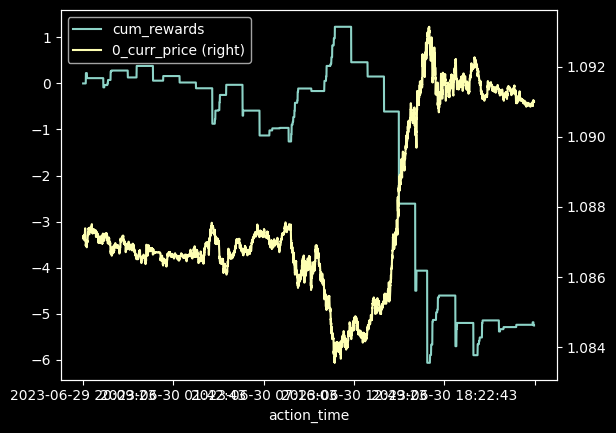

In [10]:
plot_data = res.copy()
plot_data = plot_data[['action_time','cum_rewards','0_curr_price']]
plot_data.set_index('action_time',inplace=True)
plot_data.plot(secondary_y="0_curr_price")